In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.kny import KNYImage
from ganime.data.mnist import MovingMNIST
from ganime.utils.statistics import dataset_statistics
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.net2net import Net2Net
import tensorflow as tf
import tensorflow_addons as tfa
from datetime import datetime
from tqdm import tqdm
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

In [4]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
strategy = tf.distribute.MultiWorkerMirroredStrategy()

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7'), communication = CommunicationImplementation.AUTO


2022-06-02 05:29:38.917758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-02 05:29:41.740882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-06-02 05:29:41.742184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22308 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-06-02 05:29:41.743136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/

In [6]:
cfg = omegaconf.OmegaConf.load(here("configs/moving_mnist_image_transformer.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = 16

In [7]:
train_ds = MovingMNIST("../../../data", batch_size=batch_size, split="train")
validation_ds = MovingMNIST("../../../data", batch_size=batch_size, split="validation")
test_ds = MovingMNIST("../../../data", batch_size=batch_size, split="test")

In [8]:
with strategy.scope():
    model = Net2Net(**cfg["model"])

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.


2022-06-02 05:29:44.281266: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-06-02 05:29:45.476783: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


VQLPIPSWithDiscriminator running with hinge loss.


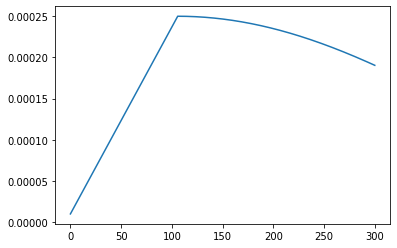

In [9]:
lrs = [model.scheduled_lrs(i) for i in range(71 * 300)]
xs = np.linspace(0, 300, len(lrs))
plt.plot(xs, lrs)

In [10]:
from ganime.utils.callbacks import TensorboardVideo, get_logdir
import os

logdir = get_logdir("../../../logs/ganime/", experiment_name="transformer_mnist_video")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_video_callback = TensorboardVideo(logdir, train_ds, test_ds)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_loss', save_best_only=True, save_weights_only=True)
callbacks = [tensorboard_callback, early_stopping, checkpointing, tensorboard_video_callback]

In [11]:
#with strategy.scope():
#    model.compile(optimizer=tfa.optimizers.AdamW(
#        learning_rate=1e-3, weight_decay=1e-4
#    ))

display_images(train_ds[0][0], 1, 3)
plt.show()

display_images(train_ds[0][1], 1, 3)
plt.show()

In [12]:
with strategy.scope():
    model.first_stage_model.build(input_shape=(None, *train_ds[0][0].shape[2:]))
    model.cond_stage_model.build(input_shape=(None, *train_ds[0][0].shape[2:]))

INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 

In [14]:
with strategy.scope():
    video = model(train_ds[0])

In [15]:
model.summary()

Model: "net2_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gpt (GPT)                   multiple                  84813312  
                                                                 
 vqgan (VQGAN)               multiple                  20186956  
                                                                 
Total params: 105,000,270
Trainable params: 104,998,468
Non-trainable params: 1,802
_________________________________________________________________


In [ ]:
model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=callbacks)

2022-06-02 05:31:32.634716: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_563678"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 132 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 2 all_reduces, num_devices =8, group_size = 8, implementation = AUTO
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 132 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 2 all_reduces, num_devices =8, group_size = 8, implementation = AUTO
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, g

2022-06-02 05:50:28.792273: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-06-02 05:50:29.565704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-06-02 05:50:30.501697: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-06-02 05:50:31.577513: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-06-02 05:50:32.820613: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-06-02 05:50:33.978222: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-06-02 05:50:35.104478: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


152/500 [========>.....................] - ETA: 5:41 - loss: 78.6638

In [ ]:
display_videos(model.process_video(train_ds[0][0].astype(np.float32))[0], 1, 3)

In [ ]:
display_videos(model.process_video(validation_ds[0][0].astype(np.float32))[0], 1, 3)

In [ ]:
display_videos(model.process_video(test_ds[0][0].astype(np.float32))[0], 1, 3)